In [215]:
import pandas as pd
import pyfredapi as pf
import os
import dowhy
from dowhy import CausalModel
import dowhy.datasets
import networkx as nx
import numpy as np
from dowhy import gcm
from causallearn.search.ConstraintBased.PC import pc
import matplotlib.pyplot as plt


os.environ["FRED_API_KEY"] = "192f8c966139a062045968b48d18fcda"

#graph.viz
#imputation to fill the gaps in the data

In [342]:
def edge_weight_calc(data, treatment,outcome):
    names = [treatment,outcome]
    
    model = CausalModel(
    data=data[names],
    treatment=treatment,
    outcome=outcome
    )

    estimand = model.identify_effect()

    #First if the method returns true that means that statisitcal analysis should be possible continue with calculating the edge weights
    if(estimand):
    
        #here We actually run the backdoor linear regression with the data in order to calculate the edge weight
        edgeWeight = model.estimate_effect(
            estimand,
            method_name="backdoor.linear_regression"
        )
    #if cannot calculate edge weights, return 0
    else:
        return 0


    tested_weight = model.refute_estimate(estimand, edgeWeight, method_name="random_common_cause")
    tested_weight2 = model.refute_estimate(estimand, edgeWeight, method_name="data_subset_refuter", subset_fraction=0.9)
    
    #if results of tests are NOT statistically significant, return the edge weight
    if((tested_weight[2] > .05) and (tested_weight2[2] > .05 )):
        return edgeWeight
    #if effects statisically significant, return 0, because this means it was a bad/weak/unstable connection
    else:
        return 0


**Converts Data Into Quarter over Quarter Percent Change**
<pre>
- goes through the dataframe column by column
- will use the pct_change method to calculate the quarter by quarter percent change (because each row is the start of a new quarter)
- drops all the empty rows (first one because it has no previous data to compare to)
- will reset the index to make up for losing the first row

In [176]:
#loops over dataframe columns does the QoQ % change for everything except the date
def convert_QoQ_change(data):
    count = 0
    for col in data.columns:
    # compute pct_change on the Series, then assign back into df
        if count != 0:
            data[col] = data[col].pct_change(fill_method=None)*100
        count = count + 1

    data = data.dropna()
    data = data.reset_index(drop=True)
    return data

**Converts CSV data that has a DAILY frequency into a proper dataframe with filled data**
<pre>
- This will first convert it into a dataframe
- Next it will use interpolation to fill in the missing data (will work only if very minimal data is missing, max a couple days at a time every once in a while)
- fixes up the dataframe and resets its index
- returns fixed up dataframe now in quarter to quarter % change

In [15]:
def daily_conversion(data, date_name):
    
    #converts the string date into a datetime object
    data[date_name] = pd.to_datetime(data[date_name])
    
    data = data.set_index(date_name).sort_index()
    data = data.asfreq('D')#fills in every calendar day thats missing, and places NaaN for each value it filled
    
    if pd.isna(data).any().any():
        data = data.interpolate(method='time')
    
    data = data.asfreq('QS')
    data = data.reset_index()
    
    data = convert_QoQ_change(data)
    
    return data

**This would deal with yearly data**
<pre>
- This would deal with datasets that are on a yearly NUMERICAL bases
- it would forward fill the data in order to fit for a quarter to quarter change
    - Concerns (approach is subject to change at the moment)
        - Will most likely to create bias/disrupt the data when calculating edge weights
- As you can see from the sample below it doesn't seem to be very affective

In [16]:
def yearly_restructure(data, date_name,numerical = True):
    
    
    data[date_name] = pd.to_datetime(data[date_name], format='%Y')
    data = data.set_index(date_name).sort_index()
    
    data = data.loc['1999':"2024"]#restricts data within time frame
    
    data = data.asfreq('QS')#fills in every quarter thats missing, and places NaaN for each value it filled
    data = data.ffill()#Forwards fills the NaaN values
    
    data = data.reset_index()
    
    if numerical == True:
        data = convert_QoQ_change(data)
        
    data = data[data['Year'] >= '2000-01-01']
    
    return data
    
    

military_spending = pd.read_csv('data/United-States-Military-SpendingDefense-Budget-Military-Spending.csv')
date_ms = military_spending.columns[0]


military_spending = yearly_restructure(military_spending, date_ms)
military_spending
    

,Year,Military Spending/Defense Budget
3,2000-01-01,7.377326
4,2000-04-01,0.000000
5,2000-07-01,0.000000
6,2000-10-01,0.000000
7,2001-01-01,3.661289
...,...,...
95,2023-01-01,6.427675
96,2023-04-01,0.000000
97,2023-07-01,0.000000
98,2023-10-01,0.000000


**Converts year long gapped data into a properly strucutred quarter to quarter filled data**

<pre>
- This would mainly be for things like majority party in congress, or party in presidency, or bills/rules that change every so couple of years
- Date column needed to be restrucutred
    - Originally in Exp: 115(Congress) (2003-2005)
    - Converter holds a needed year only

Approach:
- Just concentrate on the starting year, then depend on forward fill within the method in order to adjust the rest of the data

In [161]:
government_ideology = pd.read_csv('Data/Government ideology Datasheet.csv')
gov_ideology_date = government_ideology.columns[0]

#restructures the year data
for i in range(len(government_ideology)):
    row = government_ideology.iloc[i]
    row = row.iloc[0]

    # Split using en dash, not a regular dash
    desired_part = row.split('(')[1].split('–')[0]  # "KeepThisPart"

    government_ideology.loc[i, gov_ideology_date] = desired_part

#restructures the presidency data to keep only the party, since the name of the president isnt relevant
government_ideology['Presidency'] = (
    government_ideology['Presidency']
      # 1) drop any “ (…)" suffix
      .str.replace(r'\s*\(.*\)', '', regex=True)
      # 2) remove stray digits
      .str.replace(r'\d+',      '', regex=True)
      # 3) trim any extra whitespace
      .str.strip()
)

government_ideology = yearly_restructure(government_ideology, gov_ideology_date, numerical=False)


total_gov = pd.DataFrame(government_ideology["Party Government"])
total_gov = total_gov.reset_index(drop=True)


pre_change = pd.DataFrame(total_gov)

unification_gov = pd.DataFrame.copy(pre_change)

for index, row in total_gov.iterrows():
    if ("Unified"  in row["Party Government"]) and ("Divided" in row["Party Government"]):
        row["Party Government"] = 0
    elif "Unified" in row["Party Government"]:
        row ["Party Government"]= 1
    else:
        row["Party Government"] = 2
        
#total_gov (with the numerical change)
#unification_gov(without numerical change)

,Party Government
0,Divided
1,Divided
2,Divided
3,Divided
4,Unified / Divided
...,...
88,Unified
89,Unified
90,Unified
91,Unified


**Pulls Data From Fred API**
<pre>
Federal Surplus or Deficit variable was changed to Balance in order to follow this functionality in the future
- if it is negative, it indicates that there is a deficit (revenue < spending)
- if it is positive, it indicates there is a surplus (revenue > spending)
- possible but very unlikely situation to consider, neutral (revenue = spending)

In [305]:

#adds all of the variables into a temperary dataframe using the pyfredapi library
sc = pf.SeriesCollection(
    series_id=['GDP']
)

sc.add(series_id=["FEDFUNDS"])
sc.add(series_id=["MTSDS133FMS"])
sc.add(series_id=["FYGFDPUN"])
sc.add(series_id=["FGRECPT"])
sc.add(series_id=["FYONGDA188S"])
sc.add(series_id=["UNRATE"])
sc.add(series_id=["SPPOP65UPTOZSUSA"])
sc.add(series_id=["CPIAUCSL"])
sc.add(series_id=["GFDEBTN"])
sc.add(series_id=["GDP"])
sc.add(series_id=["EFFR"])
sc.add(series_id=["DGS10"])

#Renaming all of the variables
new_names = {
    "GDP": "GDP",
    "FEDFUNDS": "Federal Funds Effective Rate",
    "MTSDS133FMS": "Balance",
    "FYGFDPUN": "Federal Debt Held by the Public" ,
    "FGRECPT": "Federal Revenue",
    "NA000283Q":"Federal Spending" ,
    "UNRATE": "Unemployment rate",
    "W823RC1": "Using Social Security",
    "CPIAUCSL": "Inflation rate", 
    "GFDEBTN": "National Debt"
    
}
#"DGS10": "Treasury Yields"
#,"EFFR": "Federal Funds Rate"

#



'''
Variables to look into adding: Federal government budget surplus or deficit (-) (M318501Q027NBEA)
Federal government current tax receipts(how much the government collected in taxes) (W006RC1Q027SBEA)
- War
- Ideaoligy
    - Look into how to work with senate and house of rep data again along with adding presidency
    - For congress(https://history.house.gov/Institution/Party-Divisions/Party-Divisions/)
    - for Presidency()
- The feds monetary policy
-Government spending allocation
    - Maybe finding some sort of dataset that has each govenemnt spending spread from year to year
    - military Budget (https://www.macrotrends.net/global-metrics/countries/usa/united-states/military-spending-defense-budget)
'''



sc = pf.SeriesCollection(series_id=["GDP","FEDFUNDS","MTSDS133FMS","FYGFDPUN","FGRECPT","NA000283Q","UNRATE","W823RC1","CPIAUCSL","GFDEBTN"], rename=new_names)

#converts it into a dataframe where each variable has its own column
cpi_long = sc.merge_wide()

#converts from temperary dataframe being returned into a real dataframe
df = pd.DataFrame(cpi_long)

#removes unnecessary dates(keeps 1999-2024) and reorganizes index

data = df["date"]
data_df = pd.DataFrame(data)


df["date"]= pd.to_datetime(df["date"])
df.set_index('date', inplace=True)
df.sort_index(inplace=True)


start = data_df[data_df['date'] == '1999-07-01'].index[0]
end = data_df[data_df['date'] == '2024-01-01'].index[0]

data_df = data_df.iloc[start:end].reset_index(drop=True)

df = df.iloc[start:end].reset_index(drop=True).dropna()#limits the dataframe to this time constraint and removes unnecesary lines

data_df['date'] = data_df['date'].astype(str)
pattern = '01-01|04-01|07-01|10-01'
q = data_df[data_df['date'].str.contains(pattern)].to_dict('records')

p = pd.DataFrame(q)
data_df["date"] = pd.to_datetime(data_df["date"])
p = p.sort_values(by="date",ascending=True)

df['date'] = p['date'].values
labels = [
    "date",
    "GDP",
    "Federal Funds Effective Rate",
    "Balance",
    "Federal Debt Held by the Public",
    "Federal Revenue",
    "Federal Spending",
    "Unemployment rate",
    "Using Social Security",
    "Inflation rate",
    "National Debt"
]

df = df[labels]
df = convert_QoQ_change(df)

type(df)


Requesting series GDP...
Requesting series FEDFUNDS...
Requesting series MTSDS133FMS...
Requesting series FYGFDPUN...
Requesting series FGRECPT...
Requesting series FYONGDA188S...
Requesting series UNRATE...
Requesting series SPPOP65UPTOZSUSA...
Requesting series CPIAUCSL...
Requesting series GFDEBTN...
Requesting series GDP...
Requesting series EFFR...
Requesting series DGS10...
Requesting series GDP...
Requesting series FEDFUNDS...
Requesting series MTSDS133FMS...
Requesting series FYGFDPUN...
Requesting series FGRECPT...
Requesting series NA000283Q...
Requesting series UNRATE...
Requesting series W823RC1...
Requesting series CPIAUCSL...
Requesting series GFDEBTN...


pandas.core.frame.DataFrame

<pre>
Initial Variables to do Initial Graph
- Federal Deficit   MTSDS133MF3
- Federal Spending  NA000280Q
- Federal Revenue   FGRECPT
- GDP                 GDP
- Government Control (csv)
- Treasury Yields

In [306]:
df_test = ["date","GDP","Federal Spending","Balance", "Federal Revenue","National Debt"]

df_data = df[df_test]


treasury_Yield_oop = pd.read_csv("Data/Treasury_Yields.csv")
date_section_name = 'observation_date'
df_data["Goverment Ideology"] = total_gov

#df_data["Goverment Ideology"] = unification_gov
df_data['date'] = p

reorder_col = ['date',"GDP","Federal Spending","Balance", "Federal Revenue","National Debt","Goverment Ideology"]

graph_data = df_data[reorder_col]

graph_data['Goverment Ideology'] = graph_data['Goverment Ideology'].ffill()
treasury_Yield_oop = daily_conversion(treasury_Yield_oop, date_section_name)
#graph_data['Treasury Yield'] = treasury_Yield_oop['DGS10(Treasury_Yield) ']


graph_data = graph_data.iloc[:,1:]

practice_data = ["Federal Revenue", "Federal Spending","Balance", "National Debt" ]
practice_data = graph_data[practice_data]


/var/folders/19/l_my4rzn14zc4zz509mgtdl40000gn/T/ipykernel_41085/4060571720.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data["Goverment Ideology"] = total_gov
/var/folders/19/l_my4rzn14zc4zz509mgtdl40000gn/T/ipykernel_41085/4060571720.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data['date'] = p
/var/folders/19/l_my4rzn14zc4zz509mgtdl40000gn/T/ipykernel_41085/4060571720.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a f

In [307]:
# 1. Build one‐period lags and drop NaNs
df = graph_data.copy()
for col in graph_data.columns:
    df[f"{col}_lag1"] = df[col].shift(1)
df = df.dropna()

# 2. Define your causal edges and estimate β̂s
edges = [
    ("GDP", "Federal Revenue"),
    ("Federal Spending", "Balance"),
    ("Federal Revenue", "Balance"),
    ("Balance", "National Debt"),
]

results = {}
for src, tgt in edges:
    model = CausalModel(
        data=df,
        treatment= src + "_lag1",
        outcome=   tgt,
        common_causes=[f"{c}_lag1" for c in graph_data.columns if c not in {src, tgt}]
    )
    estimand = model.identify_effect()
    est      = model.estimate_effect(estimand, method_name="backdoor.linear_regression")
    results[(src, tgt)] = est.value
    print(results)

{('GDP', 'Federal Revenue'): 1.0898451596309715}
{('GDP', 'Federal Revenue'): 1.0898451596309715, ('Federal Spending', 'Balance'): -3.8291279260948965}
{('GDP', 'Federal Revenue'): 1.0898451596309715, ('Federal Spending', 'Balance'): -3.8291279260948965, ('Federal Revenue', 'Balance'): 40.550925266048566}
{('GDP', 'Federal Revenue'): 1.0898451596309715, ('Federal Spending', 'Balance'): -3.8291279260948965, ('Federal Revenue', 'Balance'): 40.550925266048566, ('Balance', 'National Debt'): 0.0002239184559276186}


/Users/simon/Desktop/Projects/National-Debt-Research/venv_nationalDebt_research/lib/python3.10/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/Users/simon/Desktop/Projects/National-Debt-Research/venv_nationalDebt_research/lib/python3.10/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/Users/simon/Desktop/Projects/National-Debt-Research/venv_nationalDebt_research/lib/python3.10/site-packages/dowhy/causal_

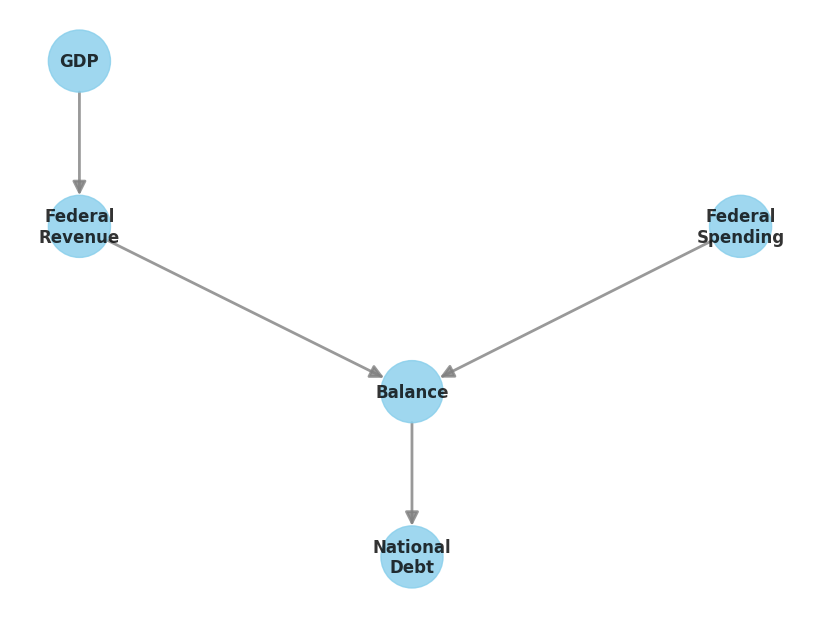

In [308]:
# 3. Turn that into a NetworkX DiGraph and stick the beta on each edge's 'label' attr
G = nx.DiGraph()
for (src, tgt), beta in results.items():
    G.add_edge(src, tgt, label=f"{beta:.2f}")

# 2. Plug it into DoWhy
first_src, first_tgt = edges[0]
viz_model = CausalModel(
    data=df,
    graph=G,
    treatment= first_src + "_lag1",
    outcome=   first_tgt
)

# 3. Render with Graphviz (labels show up)
viz_model.view_model(layout="dot")

**Graph 1 with gdp affecting federal revenue**

In [336]:
'''
graph_data['GDP_lag1']     = graph_data['GDP'].shift(1)
graph_data['Revenue_lag1']= graph_data['Federal Revenue'].shift(1)
graph_data = graph_data.dropna()

# Now your DoWhy graph uses GDP_lag1 → Revenue and Revenue_lag1 → GDP
model_gdp_revenue = CausalModel(
    data=graph_data,
    treatment="GDP_lag1",
    outcome="Federal Revenue",
    common_causes=["Revenue_lag1"]
)
gdp_revenue = model_gdp_revenue.identify_effect()

estimate_gdp_revenue = model_gdp_revenue.estimate_effect(gdp_revenue,method_name="backdoor.linear_regression")
results_gdp_revenue = model_gdp_revenue.refute_estimate(gdp_revenue,estimate_gdp_revenue,method_name="random_common_cause")
'''

'\ngraph_data[\'GDP_lag1\']     = graph_data[\'GDP\'].shift(1)\ngraph_data[\'Revenue_lag1\']= graph_data[\'Federal Revenue\'].shift(1)\ngraph_data = graph_data.dropna()\n\n# Now your DoWhy graph uses GDP_lag1 → Revenue and Revenue_lag1 → GDP\nmodel_gdp_revenue = CausalModel(\n    data=graph_data,\n    treatment="GDP_lag1",\n    outcome="Federal Revenue",\n    common_causes=["Revenue_lag1"]\n)\ngdp_revenue = model_gdp_revenue.identify_effect()\n\nestimate_gdp_revenue = model_gdp_revenue.estimate_effect(gdp_revenue,method_name="backdoor.linear_regression")\nresults_gdp_revenue = model_gdp_revenue.refute_estimate(gdp_revenue,estimate_gdp_revenue,method_name="random_common_cause")\n'

**Beta for GDP and Federal Revenue**

In [357]:
names_gdp_rev = ["GDP","Federal Revenue"]

model_gdp_rev = CausalModel(
    data=graph_data[names_gdp_rev],
    treatment="GDP",
    outcome="Federal Revenue"
)

gdp_rev_identified_estimand = model_gdp_rev.identify_effect()
'''

# The identifier object DoWhy used lives here:
identifier = gdp_rev_identified_estimand.identifier

# Many identifiers have a .method_name attribute too:
method = getattr(identifier, "method_name",
         getattr(identifier, "_method_name", None))

if method is None:
    # as last resort, infer from the class name
    cls = type(identifier).__name__      # e.g. "BackdoorAdjustment"
    method = cls.replace("Adjustment", "").lower()

print("Method used (fallback):", method)
'''
print(gdp_rev_identified_estimand)
print(gdp_rev_identified_estimand.estimand_type)
print(gdp_rev_identified_estimand.identifier_method)
'''
#First if the method returns true that means that statisitcal analysis should be possible
if(gdp_rev_identified_estimand):
   
    #here We actually run the backdoor linear regression with the data in order to calculate the edge weight
    gdp_rev_edgeWeight = model_gdp_rev.estimate_effect(
        gdp_rev_identified_estimand,
        method_name="backdoor.linear_regression"
    )


tested_weight = model_gdp_rev.refute_estimate(gdp_rev_identified_estimand, gdp_rev_edgeWeight, method_name="random_common_cause")

tested_weight2 = model_gdp_rev.refute_estimate(gdp_rev_identified_estimand, gdp_rev_edgeWeight, method_name="data_subset_refuter", subset_fraction=0.9)

#These tests will prove how strong causalites strength is
print("This is the random_common_cause tested weight",tested_weight)
print("This is the removing subset of data tested weight",tested_weight2)
'''


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
──────(E[Federal Revenue])
d[GDP]                    
Estimand assumption 1, Unconfoundedness: If U→{GDP} and U→Federal Revenue then P(Federal Revenue|GDP,,U) = P(Federal Revenue|GDP,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

EstimandType.NONPARAMETRIC_ATE
None


'\n#First if the method returns true that means that statisitcal analysis should be possible\nif(gdp_rev_identified_estimand):\n   \n    #here We actually run the backdoor linear regression with the data in order to calculate the edge weight\n    gdp_rev_edgeWeight = model_gdp_rev.estimate_effect(\n        gdp_rev_identified_estimand,\n        method_name="backdoor.linear_regression"\n    )\n\n\ntested_weight = model_gdp_rev.refute_estimate(gdp_rev_identified_estimand, gdp_rev_edgeWeight, method_name="random_common_cause")\n\ntested_weight2 = model_gdp_rev.refute_estimate(gdp_rev_identified_estimand, gdp_rev_edgeWeight, method_name="data_subset_refuter", subset_fraction=0.9)\n\n#These tests will prove how strong causalites strength is\nprint("This is the random_common_cause tested weight",tested_weight)\nprint("This is the removing subset of data tested weight",tested_weight2)\n'

/Users/simon/Desktop/Projects/National-Debt-Research/venv_nationalDebt_research/lib/python3.10/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/Users/simon/Desktop/Projects/National-Debt-Research/venv_nationalDebt_research/lib/python3.10/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/Users/simon/Desktop/Projects/National-Debt-Research/venv_nationalDebt_research/lib/python3.10/site-packages/dowhy/causal_

GDP -> Federal Revenue: β̂ = 1.4658
Federal Spending -> Balance: β̂ = 2.4917
Federal Revenue -> Balance: β̂ = 55.8175
Balance -> National Debt: β̂ = 0.0003


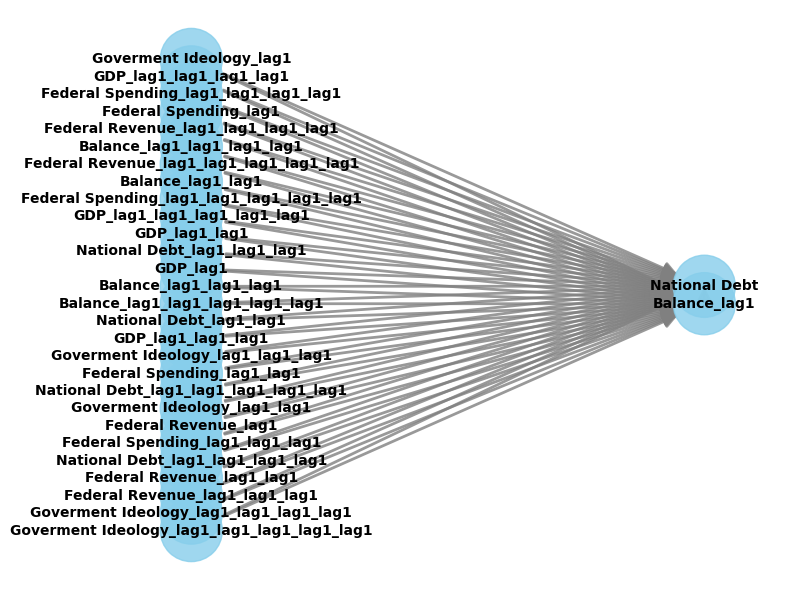

In [315]:
lagged = {}
for col in graph_data.columns:
    lagged[col + "_lag1"] = graph_data[col].shift(1)
graph_data = graph_data.assign(**lagged).dropna()

# 3. Define your edges
edges = [
    ("GDP", "Federal Revenue"),
    ("Federal Spending", "Balance"),
    ("Federal Revenue", "Balance"),
    ("Balance", "National Debt")
]
results = {}
for src, tgt in edges:
    treatment = src + "_lag1"
    outcome   = tgt
    # common causes = all other lagged vars except the one we intervene on
    common_causes = [
        col + "_lag1" 
        for col in graph_data.columns 
        if col + "_lag1" in graph_data.columns 
           and col not in {src, tgt}
    ]
    
    model = CausalModel(
        data=graph_data,
        treatment=treatment,
        outcome=outcome,
        common_causes=common_causes
    )
    estimand = model.identify_effect()
    est      = model.estimate_effect(
                  estimand, 
                  method_name="backdoor.linear_regression"
               )
    results[f"{src} -> {tgt}"] = est.value

# 5. Print the estimated edge-weights
for edge, beta in results.items():
    print(f"{edge}: β̂ = {beta:.4f}")
    
model.view_model()
    


In [313]:
for item in results:
    print(item)

GDP -> Federal Revenue
Federal Spending -> Balance
Federal Revenue -> Balance
Balance -> National Debt


In [11]:
#generates data
data = dowhy.datasets.linear_dataset(
    beta=10,
    num_common_causes=5,
    num_instruments=2,
    num_samples=10000
)

#causal model with data
model = CausalModel(
    data=data["df"],
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    graph=data["gml_graph"])


#identify causal effect and return target estimands
indentified_est = model.identify_effect()

#estimate target using statisitcal method
estimate = model.estimate_effect(indentified_est,method_name="backdoor.propensity_score_matching")

#refute estimate using multiple robustness checks
refute_results = model.refute_estimate(indentified_est,estimate,method_name="random_common_cause")

**Graphical Causal model example using info from above**

Evaluating set functions...: 100%|██████████| 8/8 [00:00<00:00, 14290.64it/s]


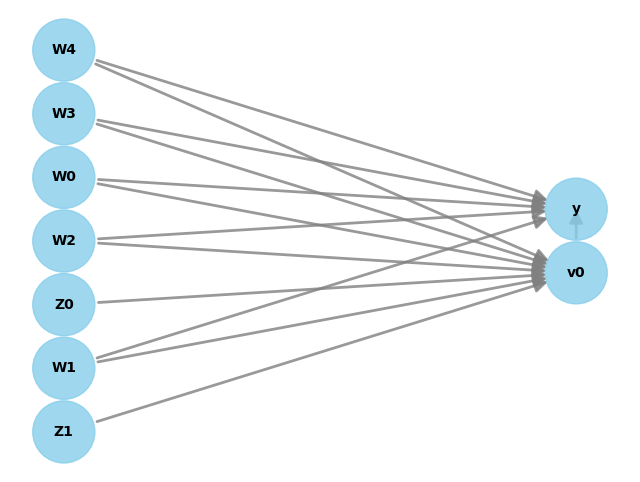

In [12]:
X = np.random.normal(loc=0,scale=1,size=10000)
Y = 2 * X + np.random.normal(loc=0,scale=1,size=10000)
Z = 3 * Y + np.random.normal(loc=0,scale=1,size=10000)
data = pd.DataFrame(dict(X=X, Y=Y,Z=Z))

causal_model = gcm.StructuralCausalModel(nx.DiGraph([('X', 'Y'), ('Y','Z')]))
gcm.auto.assign_causal_mechanisms(causal_model,data)


gcm.fit(causal_model,data)

anamalous_sample = pd.DataFrame(dict(X=[0.1],Y=[6.2], Z=[19]))


anamaly_attribution = gcm.attribute_anomalies(causal_model,"Z", anamalous_sample)
model.view_model()